In [1]:
# dependencies import
from common_dependencies import *
from train_dependencies import *

In [2]:
# paths for files with original data
PATH_TO_DATA = {
    'run_1': 
        ('data/original_data/run_1/run1_WM32_data.csv',
        'data/original_data/run_1/run1_WM32_defects.csv',
        'data/original_data/run_1/run1_WM32_pipe.csv'),
    'run_2':
        ('data/original_data/run_2/run2_WM32_data.csv',
        'data/original_data/run_2/run2_WM32_defects.csv',
        'data/original_data/run_2/run2_WM32_pipe.csv')
}

CROP_SIZE = 8
CROP_STEP = 1 #2

# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)
np.random.seed(290)

In [3]:
x_df, y_df = dw.get_x_and_y_data(*PATH_TO_DATA['run_1'])

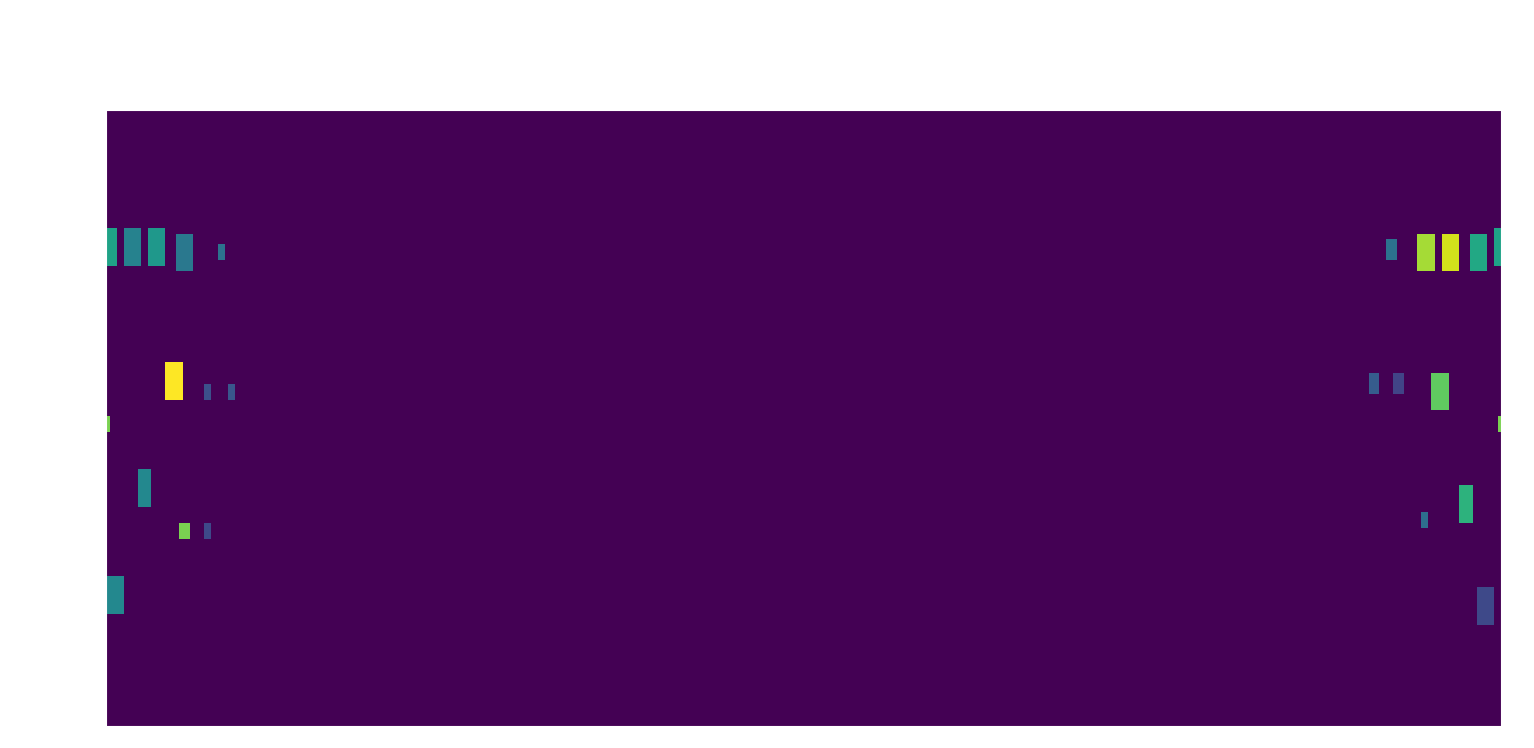

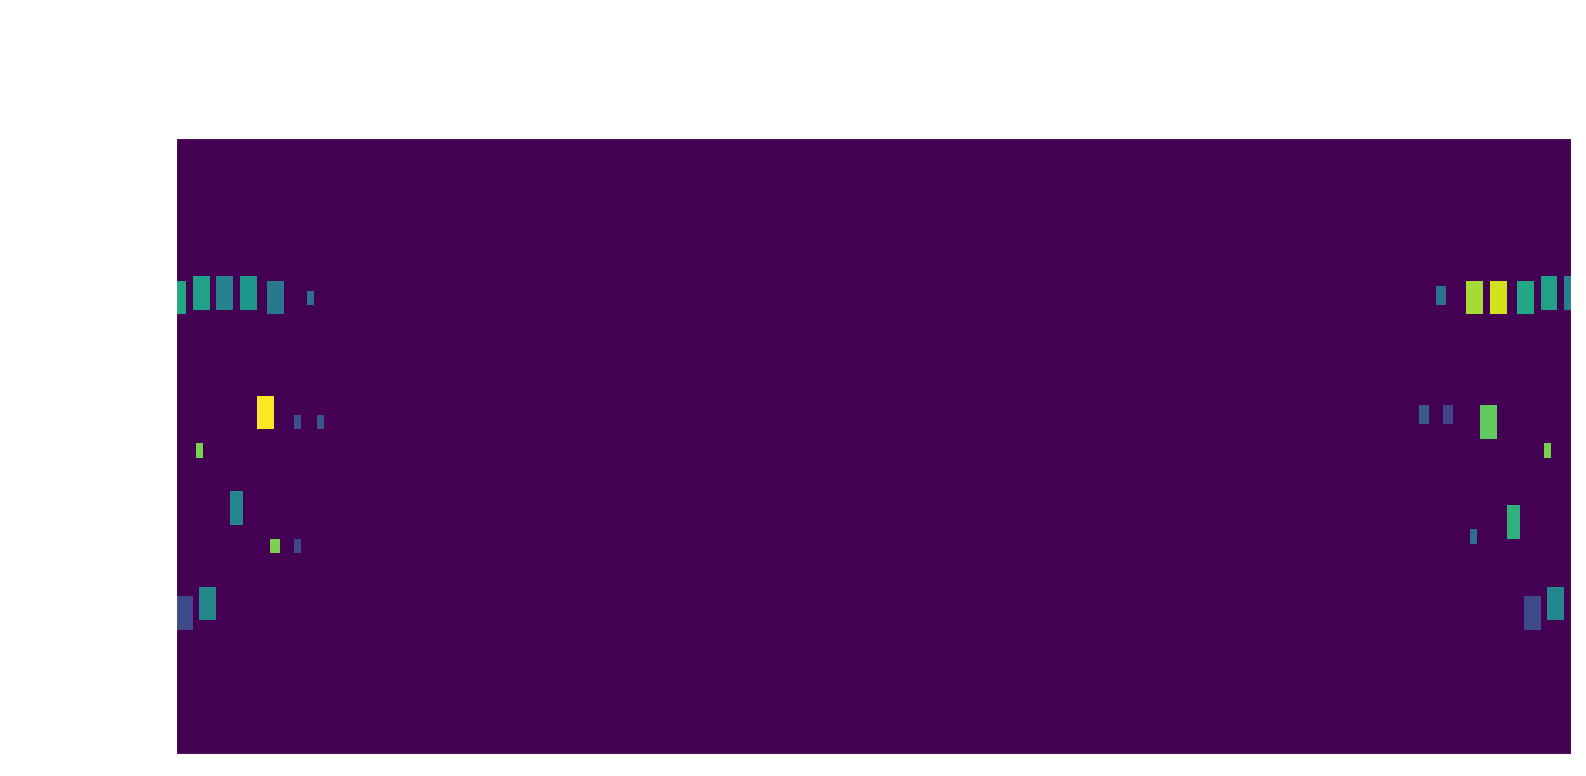

In [4]:
dw.draw_defects_map(y_df, title='Считанная развернутая карта дефектов')
x_df = dw.extend_df_for_prediction(x_df, crop_size=CROP_SIZE, crop_step=CROP_STEP)
y_df = dw.extend_df_for_prediction(y_df, crop_size=CROP_SIZE, crop_step=CROP_STEP)
dw.draw_defects_map(y_df, title='Расширенная развернутая карта дефектов')

In [7]:
# преобразовать данные к виду (измерение, размер х, размер у, каналы)
# для x_data_time каналы = 32
# для x_data_amp каналы = 32
# для y_data каналы = 1
(x_data_time,
x_data_amp) = dw.reshape_x_df_to_image_like_numpy(x_df, CROP_SIZE, CROP_STEP)
y_data = dw.reshape_y_df_to_image_like_numpy(y_df, CROP_SIZE, CROP_STEP)

||||||||||||||||||
X df reshaping to 4D
Original df size:  (129, 414)
Crop windows height/width:  8
Crop windows step across rows and cols:  1
New x_time shape:  (49654, 8, 8, 32)
New x_amp shape:  (49654, 8, 8, 32)
||||||||||||||||||

||||||||||||||||||
Y df reshaping to 3D
Original df size:  (129, 414)
Crop windows height/width:  8
Crop windows step across rows and cols:  1
New numpy shape:  (49654, 8, 8, 1)
||||||||||||||||||



In [8]:
# нормализовать входные данные
x_data_time = dw.standartize_data(x_data_time)
x_data_amp = dw.standartize_data(x_data_amp)

||||||||||||||||||
Data standartizing
arr_max before standartize: 44.5
arr_min before standartize: 0.0
arr_max after standartize: 1.0
arr_min after standartize: 0.0
||||||||||||||||||

||||||||||||||||||
Data standartizing
arr_max before standartize: 62.992
arr_min before standartize: -61.968
arr_max after standartize: 1.0
arr_min after standartize: -0.983743967487935
||||||||||||||||||



In [9]:
# Поделить кропы на дефектные и нет
(x_time_def, x_time_non_def), \
(x_amp_def, x_amp_non_def), \
(y_mask_def, y_mask_non_def) = dw.split_def_and_non_def_data(x_data_time, 
                                                            x_data_amp, 
                                                            y_data, CROP_SIZE)
x_data_time = x_data_amp = y_data = None

||||||||||||||||||
Defect and non defect data splitting
Orig x_time shape:  (49654, 8, 8, 32)
Orig x_amp shape:  (49654, 8, 8, 32)
Orig y_mask shape:  (49654, 8, 8, 1)
||||||||||||||||||
Defects nums calculating
For  49654 crops of size: 8
there are 2858 defect crops
||||||||||||||||||

x_time_def shape:  (2858, 8, 8, 32)
x_time_non_def shape:  (46796, 8, 8, 32)

x_amp_def shape:  (2858, 8, 8, 32)
x_amp_non_def shape:  (46796, 8, 8, 32)

y_mask_def shape:  (2858, 8, 8, 1)
y_mask_non_def shape:  (46796, 8, 8, 1)

||||||||||||||||||



In [10]:
shuffled_indices = np.random.permutation(x_amp_non_def.shape[0])[:x_time_def.shape[0]]

x_time_non_def = x_time_non_def[shuffled_indices]
x_amp_non_def = x_amp_non_def[shuffled_indices]
y_mask_non_def = y_mask_non_def[shuffled_indices]

print('/'*8, 'Result def and non_def data' ,'/'*8)
print(f'{x_time_def.shape=}')
print(f'{x_amp_def.shape=}')
print(f'{y_mask_def.shape=}\n')

print(f'{x_time_non_def.shape=}')
print(f'{x_amp_non_def.shape=}')
print(f'{y_mask_non_def.shape=}')

//////// Result def and non_def data ////////
x_time_def.shape=(2858, 8, 8, 32)
x_amp_def.shape=(2858, 8, 8, 32)
y_mask_def.shape=(2858, 8, 8, 1)

x_time_non_def.shape=(2858, 8, 8, 32)
x_amp_non_def.shape=(2858, 8, 8, 32)
y_mask_non_def.shape=(2858, 8, 8, 1)


In [11]:
# Аугментировать данные
x_time_def = dw.augment_data(x_time_def) 
x_time_non_def = dw.augment_data(x_time_non_def) 

x_amp_def = dw.augment_data(x_amp_def) 
x_amp_non_def = dw.augment_data(x_amp_non_def) 

y_mask_def = dw.augment_data(y_mask_def) 
y_mask_non_def = dw.augment_data(y_mask_non_def) 

||||||||||||||||||
Data augmentation
Orig arr shape:  (2858, 8, 8, 32)
||||||||||||
After 4 steps of 90 degree rotate
arr shape:  (11432, 8, 8, 32)
||||||||||||
After horizontal full mirroring
arr shape:  (22864, 8, 8, 32)
||||||||||||
After vertical full mirroring
arr shape:  (45728, 8, 8, 32)
||||||||||||||||||

||||||||||||||||||
Data augmentation
Orig arr shape:  (2858, 8, 8, 32)
||||||||||||
After 4 steps of 90 degree rotate
arr shape:  (11432, 8, 8, 32)
||||||||||||
After horizontal full mirroring
arr shape:  (22864, 8, 8, 32)
||||||||||||
After vertical full mirroring
arr shape:  (45728, 8, 8, 32)
||||||||||||||||||

||||||||||||||||||
Data augmentation
Orig arr shape:  (2858, 8, 8, 32)
||||||||||||
After 4 steps of 90 degree rotate
arr shape:  (11432, 8, 8, 32)
||||||||||||
After horizontal full mirroring
arr shape:  (22864, 8, 8, 32)
||||||||||||
After vertical full mirroring
arr shape:  (45728, 8, 8, 32)
||||||||||||||||||

||||||||||||||||||
Data augmentation
Orig arr shape:

In [12]:
# создание выходных данных бинарного вида (одномерный массив типа bool)
y_binary_def = dw.create_binary_arr_from_mask_arr(y_mask_def)
y_binary_non_def = dw.create_binary_arr_from_mask_arr(y_mask_non_def)

||||||||||||||||||
Y binary arr from Y mask arr creation
Y mask arr shape:  (45728, 8, 8, 1)
Y binary arr shape:  (45728,)
||||||||||||||||||

||||||||||||||||||
Y binary arr from Y mask arr creation
Y mask arr shape:  (45728, 8, 8, 1)
Y binary arr shape:  (45728,)
||||||||||||||||||



In [13]:
# деление на тренировочную и валидационную выборки

val_data_percent = 0.3

X_time_train, X_time_val = dw.split_data_to_train_val_datasets([x_time_def,
                                                                x_time_non_def],
                                                                val_data_percent)

X_amp_train, X_amp_val = dw.split_data_to_train_val_datasets([x_amp_def,
                                                              x_amp_non_def],
                                                              val_data_percent)

Y_binary_train, Y_binary_val = dw.split_data_to_train_val_datasets([y_binary_def,
                                                                y_binary_non_def],
                                                                val_data_percent)

||||||||||||||||||
Data spliting to test, val and train datasets
Orig item shape:  (45728, 8, 8, 32)
Orig item shape:  (45728, 8, 8, 32)

Result arr_train shape:  (64020, 8, 8, 32)
Result arr_val shape:  (27436, 8, 8, 32)

||||||||||||||||||

||||||||||||||||||
Data spliting to test, val and train datasets
Orig item shape:  (45728, 8, 8, 32)
Orig item shape:  (45728, 8, 8, 32)

Result arr_train shape:  (64020, 8, 8, 32)
Result arr_val shape:  (27436, 8, 8, 32)

||||||||||||||||||

||||||||||||||||||
Data spliting to test, val and train datasets
Orig item shape:  (45728,)
Orig item shape:  (45728,)

Result arr_train shape:  (64020,)
Result arr_val shape:  (27436,)

||||||||||||||||||



In [14]:
# перемешивание данных
train_shuffled_indices = np.random.permutation(X_time_train.shape[0])
val_shuffled_indices = np.random.permutation(X_time_val.shape[0])

X_time_train = X_time_train[train_shuffled_indices]
X_amp_train = X_amp_train[train_shuffled_indices]
Y_binary_train = Y_binary_train[train_shuffled_indices]

X_time_val = X_time_val[val_shuffled_indices]
X_amp_val = X_amp_val[val_shuffled_indices]
Y_binary_val = Y_binary_val[val_shuffled_indices]

In [15]:
print(f'{X_time_train.shape=}')
print(f'{X_amp_train.shape=}')
print(f'{Y_binary_train.shape=}\n')

print(f'{X_time_val.shape=}')
print(f'{X_amp_val.shape=}')
print(f'{Y_binary_val.shape=}')

X_time_train.shape=(64020, 8, 8, 32)
X_amp_train.shape=(64020, 8, 8, 32)
Y_binary_train.shape=(64020,)

X_time_val.shape=(27436, 8, 8, 32)
X_amp_val.shape=(27436, 8, 8, 32)
Y_binary_val.shape=(27436,)


In [14]:
# всякие константы для последующей работы

#///////////////////////////////// для компиляции 

CMP_learning_rate = 0.000001 #0.04 # шаг сходимости back propogation
CMP_solver = keras.optimizers.Adam(CMP_learning_rate) # оптимизатор
#CMP_solver = keras.optimizers.SGD(CMP_learning_rate) # оптимизатор
CMP_loss_func = 'mean_squared_error'# функция потерь
#///////////////////////////////// для колбэков

    # для Early_stopping
#ES_patience = 15 # кол-во эпох без улучшений
#ES_min_delta = 0.0005 # минимальное улучшение параметра за cur_patience
#ES_monitor_parametr =  'loss' # отслеживаемый параметр 
#ES_save_best_weights = False # сохранять ли веса нейронки с лучшими результатами
    
    # для ReduceLROnPlateau
#RLPOP_monitor_parametr = 'loss'  # отслеживаемый параметр 
#RLPOP_factor = 0.4 # множитель для расчета нового шага сходимости (new_learning_rate = old_learning_rate*RLPOP_factor)
#RLPOP_patience = 10 # кол-во эпох без улучшений
#RLPOP_verbose = 1 # выводить ли прогресс изменения шага сходимости в его процессее
#RLPOP_mode = 'auto' # выбирает, уменьшать шаг сходимости при росте величины или при её уменьшении
#RLPOP_min_delta = 0.001 # порог изменения отслеживаемого значения
#RLPOP_cooldown = 0 # количество эпох до возобновления работы после изменения шага сходимости
#RLPOP_min_lr = 0 # минимальное значение шага сходимости

    # для CallbackList
CBL_add_history = True # вызывать ли колбэк History (если он не был довавлен вручную)
CBL_add_progbar = True # вызывать ли колбэк ProgbarLogger (если он не был довавлен вручную)
    
#///////////////////////////////// для тренировки

FIT_batch_size = 32 # размер bach при обучении/тестировании1
#FIT_shuffle = True # перемешивать ли данные
FIT_verbose = True # выводить ли прогресс обучения в его процессее
FIT_epochs = 15 # количество эпох обучения
#FIT_validation_split = 0.10 #0.20 # процент валидационных данных, отсекаемых из тестовой выборки

In [15]:
# создание архитектуры модели
#DROP_PERCENT = 0
# 1 подсеть //////////////////////////////////////////////////
input_time = Input((8,8,32), name = 'input_time')

conv_1_1 = Conv2D(1024, (3,3), activation='relu', name='conv_1_1')(input_time)
conv_1_2 = Conv2D(1024, (3,3), activation='relu', name='conv_1_2')(conv_1_1)
conv_1_3 = Conv2D(1024, (3,3), activation='relu', name='conv_1_3')(conv_1_2)
pool_1_1 = MaxPooling2D((2,2), strides=2, name='pool_1_1')(conv_1_3)

# 2 подсеть //////////////////////////////////////////////////
input_amp = Input((8,8,32), name = 'input_amp')

conv_2_1 = Conv2D(1024, (3,3), activation='relu', name='conv_2_1')(input_amp)
conv_2_2 = Conv2D(1024, (3,3), activation='relu', name='conv_2_2')(conv_2_1)
conv_2_3 = Conv2D(1024, (3,3), activation='relu', name='conv_2_3')(conv_2_2)
pool_2_1 = MaxPooling2D((2,2), strides=2, name='pool_2_1')(conv_2_3)

# выходная подсеть //////////////////////////////////////////////////

conc_3_1 = concatenate([pool_1_1, pool_2_1], axis=3, name='conc_3_1')
flat_3_1 = Flatten(name='flat')(conc_3_1)

#d_3_1 = Dense(8192, activation='linear', name='d_3_1')(flat_3_1)
d_3_1 = Dense(4096, activation='linear', name='d_3_1')(flat_3_1)
d_3_2 = Dense(2048, activation='linear', name='d_3_2')(d_3_1)
d_3_3 = Dense(512, activation='linear', name='d_3_3')(d_3_2)
d_3_4 = Dense(128, activation='linear', name='d_3_4')(d_3_3)
d_3_5 = Dense(32, activation='linear', name='d_3_5')(d_3_4)
d_3_6 = Dense(8, activation='linear', name='d_3_6')(d_3_5)

output_3_1 = Dense(1, activation='sigmoid', name='output_3_1')(d_3_6)

model = keras.Model([input_time, input_amp], output_3_1, name='model')

model.compile(optimizer=CMP_solver, loss=CMP_loss_func)

print(model.summary())



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_time (InputLayer)     [(None, 8, 8, 32)]           0         []                            
                                                                                                  
 input_amp (InputLayer)      [(None, 8, 8, 32)]           0         []                            
                                                                                                  
 conv_1_1 (Conv2D)           (None, 6, 6, 1024)           295936    ['input_time[0][0]']          
                                                                                                  
 conv_2_1 (Conv2D)           (None, 6, 6, 1024)           295936    ['input_amp[0][0]']           
                                                                                            

In [16]:
# Создание и настройка колбэков

callback_list = [] # массив колбэков до подачи в колбек "callbacklist"

FIT_callback_list = keras.callbacks.CallbackList(
            callbacks = callback_list, 
            add_history = CBL_add_history, 
            add_progbar = CBL_add_progbar, 
            model = model
            )

In [17]:
history = model.fit([X_time_train, X_amp_train],
                    Y_binary_train,
                    batch_size = FIT_batch_size, 
                    epochs = FIT_epochs, 
                    verbose = FIT_verbose, 
                    validation_data = ([X_time_val, X_amp_val], Y_binary_val), 
                    callbacks = FIT_callback_list)


2001/2001 [==============================] - 707s 354ms/step - loss: 0.0011 - val_loss: 0.0022


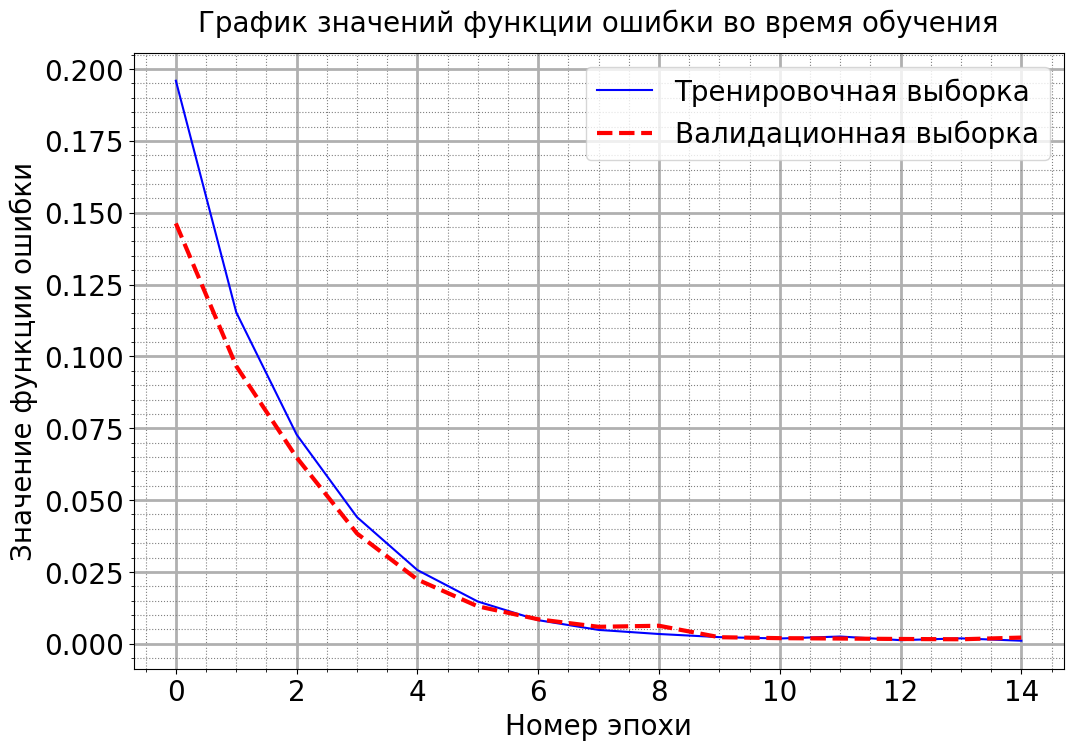

In [18]:
fig, ax = plt.subplots()

fig.set_figwidth(12)
fig.set_figheight(8)

plt.plot(history.history['loss'], 
         label='Тренировочная выборка',  linewidth=1.5, color='blue')
plt.plot(history.history['val_loss'], linestyle = '--', 
         label='Валидационная выборка',  linewidth=3, color='red')

ax.set_xlabel('Номер эпохи', fontsize=20)
ax.set_ylabel('Значение функции ошибки', fontsize=20)
ax.set_title(f"График значений функции ошибки во время обучения", fontsize=20, pad=15)

ax.patch.set_alpha(0)

#  Устанавливаем форматирование делений:
ax.tick_params(axis='both', which='both', labelsize = 20)

# Вывод и настройка сетки
ax.minorticks_on()
ax.grid(which='major', linewidth=2)
ax.grid(which='minor', color = 'gray', linestyle = ':')

ax.legend(fontsize = 20, facecolor = "white", loc = 'upper right')

plt.show()

In [19]:
# сохранение модели в файл
#model.save(f"networks/CNN/id=07_in(8x8+8x8)_out(1)_train=0dot0_test=0dot0.h5", save_format="h5")

C:\Users\emis\AppData\Local\anaconda3\envs\Network\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
